# Neurosymbolic Software Tutorial - Discrete - Solution

<a target="_blank" href="https://colab.research.google.com/github/kavigupta/neurosym-lib/blob/main/tutorial/discrete_exercise_solutions.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Instruction
- Navigating this notebook on Google Colab: There will be text blocks and code blocks throughout the notebook. The text blocks, such as this one, will contain instructions and questions for you to consider. The code blocks, such as the one below, will contain executible code. Sometimes you will have to modify the code blocks following the instructions in the text blocks. You can run the code block by either pressing control/cmd + enter or by clicking the arrow on left-hand side.
- Saving Work: If you wish to save your work in this .ipynb, we recommend downloading the compressed repository from GitHub, unzipping it, uploading it to Google Drive, and opening this notebook from within Google Drive.


## Outline

- Part 1: Defining a DSL
- Part 2: Finding Programs
- Part 3: Abstraction Learning

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import itertools
import neurosym as ns
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("error")

from neurosym.examples.simple_dreamcoder.domain import *


In [2]:
dsl = ns.examples.simple_dreamcoder.domain.example_dsl()

In [3]:
print(dsl.render())

              0 :: () -> f
              1 :: () -> f
              2 :: () -> f
              + :: (f, f) -> f
              - :: (f, f) -> f
              * :: (f, f) -> f
             ** :: (f, f) -> f
              / :: (f, f) -> f
            sin :: f -> f
           sqrt :: f -> f
              < :: (f, f) -> b
            ite :: (b, f, f) -> f
            lam :: L<#body|f> -> f -> #body
           $0_0 :: V<f@0>


In [4]:
xs, values = ns.examples.simple_dreamcoder.example_dataset(1000, 20)
plot_count = 3

def plot_some_sequences():
    for i in range(plot_count):
        plt.plot(xs, values[i], color=f"C{i}", alpha=0.25)
        plt.scatter(xs, values[i], color=f"C{i}", marker=".")

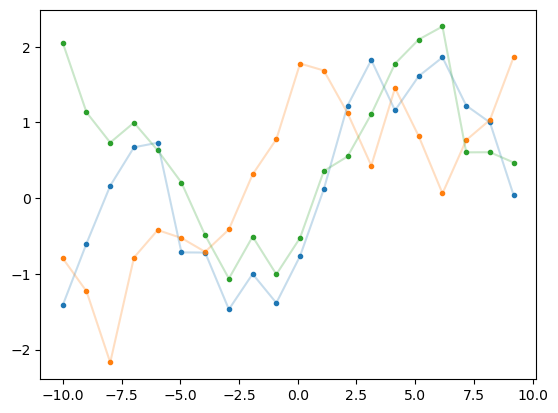

In [5]:
plot_some_sequences()

In [6]:
def plot_programs_against_data(dsl, best_programs):
    plot_some_sequences()
    best_programs = best_programs[:plot_count]
    _, evals = evaluate_all_programs(xs, dsl, best_programs)
    for prog, ev in zip(best_programs, evals):
        plt.plot(xs, ev, label=ns.render_s_expression(prog).replace("$", r"\$"))
    plt.legend()


We provide a function for finding the best program out of a list that matches a given data sequence:

Now we find the best programs among the first 50k enumerated programs

In [7]:
xs.shape, values.shape

((20,), (1000, 20))

In [10]:
for updated_dsl, best_programs in full_algorithm(xs, values, dsl):
    continue

Mean error:  15.650219661625867
Mean error:  10.662564970414543
Mean error:  8.67352483052536
Mean error:  7.976384966612577
Mean error:  7.580391543353699


KeyboardInterrupt: 

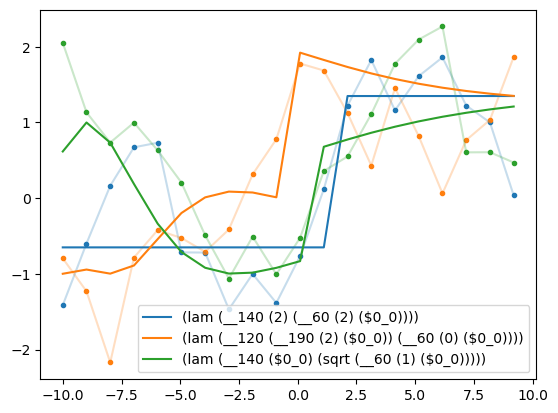

In [11]:
plot_programs_against_data(updated_dsl, best_programs)

In [47]:
((evaluate_all_programs(xs, dsl, best_programs)[1] - values) ** 2).sum(-1).mean()

15.650219661625867

Mean error:  10.662564970414543


### Exercise 3A: Fitting a DSL

Fit a function to the `best_programs`. Useful functions to know are `dist_family.fit_distribution` and `distribution.bound_minimum_likelihood`. Use a parameter of 0.01 as the minimum likelihood.

In [ ]:
# BEGIN SOLUTION fitted_dist = ______
fitted_dist = dist_family.fit_distribution(best_programs).bound_minimum_likelihood(0.01)
# END SOLUTION

We then check the fit. This should lead to a lower mean error:

In [ ]:
best_programs_fitted = best_fits(dsl, dist_family, fitted_dist)

In [ ]:
plot_programs_against_data(dsl, best_programs_fitted)

### Exercise 3B: Abstractions

You can use the function `ns.compression.multi_step_compression` to get a new dsl and rewritten programs. Use this function to create a new DSL with 5 new abstractions and a new distribution

In [ ]:
# BEGIN SOLUTION abstraction_dsl, abstraction_family, abstraction_dist = ______
abstraction_dsl, rewritten = ns.compression.multi_step_compression(dsl, best_programs_fitted, 5)
abstraction_family = ns.BigramProgramDistributionFamily(abstraction_dsl)
abstraction_dist = abstraction_family.fit_distribution(rewritten).bound_minimum_likelihood(0.01)
# END SOLUTION

You can see your printed DSL here

In [ ]:
print(abstraction_dsl.render())

We now can see how this effects our program fitting

In [ ]:
best_programs_abstractions = best_fits(abstraction_dsl, abstraction_family, abstraction_dist)

In [ ]:
plot_programs_against_data(abstraction_dsl, best_programs_abstractions)

## Part 4: Bonus: Python DSL Subset

This section does not contain any exercises, and exists only as a showcase of the Python DSL Subset feature of the neurosymbolic library.

First, we have a method for converting Python code into s-expressions compatible with the neurosym library

In [ ]:
code = """
x = 2
y = 2 + x
z = x + y
"""

code_s = ns.python_to_type_annotated_ns_s_exp(code)
ns.render_s_expression(code_s)

We would like to be able to fit distributions to these programs, but unfortunately the Python DSL is infinite in our framework, as we do not support arbitrary leaves. Thus, we need to establish a DSL subset.

In [ ]:
subset = ns.PythonDSLSubset.from_s_exps([code_s])

We can then create Python DSL as such. Note that the DSL produced is quite large.

In [ ]:
dsl_python = ns.create_python_dsl(ns.python_dfa(), subset, "M")
print(dsl_python.render())

We can enumerate some programs from this DSL, adding in a `DefUseChainPreorderMask` which enforces that our distribution only produces programs where the def-use chains are all valid

In [ ]:
python_family = ns.BigramProgramDistributionFamily(
    dsl_python,
    additional_preorder_masks=[
        lambda dist, dsl: ns.python_def_use_mask.DefUseChainPreorderMask(
            dist, dsl, ns.python_def_use_mask.DefUseMaskConfiguration(ns.python_dfa(), {})
        )
    ],
    node_ordering=ns.python_def_use_mask.PythonNodeOrdering,
)

In [ ]:
python_dist = python_family.fit_distribution([code_s])

Note that in all the produced programs, def-use chains are preserved

In [ ]:
for x, like in itertools.islice(python_family.enumerate(python_dist), 10):
    print(ns.s_exp_to_python(x))
    print("*" * 100)